In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from work.pipelines.word_helpers.nodes import *

In [19]:
narrative_ts = {
    'pride_prej': catalog.load('gb_ts_pride_prej').split(),
    'frankenstein': catalog.load('gb_ts_frankenstein').split(),
    'moby_dick': catalog.load('gb_ts_moby_dick').split()
}


[02/28/24 15:41:10] INFO     Loading data from 'gb_ts_pride_prej' (TextDataset)...              ]8;id=924796;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=904020;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'gb_ts_frankenstein' (TextDataset)...            ]8;id=827445;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=630018;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'gb_ts_moby_dick' (TextDataset)...               ]8;id=353024;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=237534;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [20]:
for k, v in narrative_ts.items():

    print(f'{k}\t length: {len(v)}')

pride_prej	 length: 143359
frankenstein	 length: 87275
moby_dick	 length: 244170


In [21]:
labMT = catalog.load('labMT')
labMT.head()

                    INFO     Loading data from 'labMT' (CSVDataset)...                          ]8;id=760656;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=352933;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/site-packages/kedro/io/data_catalog.py#502\502]8;;\

,rank,word,english,happiness,std
0,0,laughter,laughter,8.50,0.93
1,1,happiness,happiness,8.44,0.97
2,2,love,love,8.42,1.11
3,3,happy,happy,8.30,0.99
4,4,laughed,laughed,8.26,1.16


In [22]:
def happiness_from_narrative_ts(narrative_ts: list, map: pd.DataFrame, coerce_to_lower=True) -> pd.DataFrame:
    '''Join with `map` to produce happiness time series.'''

    idx = 'word'
    df = pd.DataFrame(narrative_ts, columns=['word'])

    if coerce_to_lower:
        df['word'] = [w.lower() for w in df['word']]

    df = (df
    .join(map.set_index(idx), on=idx)
    .dropna(subset='happiness')
    # .reset_index(drop=True)
    .reset_index(names='word_order')
    )

    return df


def compile_texts(ts_lists: list, names: list):

    df = pd.DataFrame()

    for ts, name in zip(ts_lists, names):
        tmp = happiness_from_narrative_ts(ts, labMT)
        tmp['corpus'] = name

        df = pd.concat([df, tmp], axis=0)

    return df

texts = compile_texts(narrative_ts.values(), narrative_ts.keys())
texts


,word_order,word,rank,english,happiness,std,corpus
0,0,chapter,4268.0,chapter,5.60,1.21,pride_prej
1,2,it,7076.0,it,5.02,0.74,pride_prej
2,3,is,6328.0,is,5.18,0.72,pride_prej
3,4,a,6018.0,a,5.24,0.92,pride_prej
4,5,truth,235.0,truth,7.42,1.40,pride_prej
...,...,...,...,...,...,...,...
171467,244162,missing,9774.0,missing,2.98,1.38,moby_dick
171468,244163,children,470.0,children,7.12,1.35,moby_dick
171469,244165,only,7547.0,only,4.92,1.16,moby_dick
171470,244166,found,1222.0,found,6.54,1.18,moby_dick


In [23]:
filter_delta_h(texts, lens=(4,6))

,word_order,word,rank,english,happiness,std,corpus
4,5,truth,235.0,truth,7.42,1.40,pride_prej
5,7,acknowledged,2289.0,acknowledged,6.10,1.43,pride_prej
14,17,good,408.0,good,7.20,1.46,pride_prej
15,18,fortune,304.0,fortune,7.30,1.39,pride_prej
22,26,wife,1093.0,wife,6.62,1.81,pride_prej
...,...,...,...,...,...,...,...
171454,244145,up,2231.0,up,6.14,1.53,moby_dick
171456,244147,last,9296.0,last,3.74,1.26,moby_dick
171467,244162,missing,9774.0,missing,2.98,1.38,moby_dick
171468,244163,children,470.0,children,7.12,1.35,moby_dick


In [24]:
def generate_emotional_arc(df, delta_h, mu, label, color, ax):

    df = filter_delta_h(df, lens=delta_h)
    
    window = int(10**mu)
    df['h_smooth'] = df['happiness'].rolling(window=window).mean()
    
    title = f'{label}, $\Delta h$={delta_h}, smoothing T={window}'

    ax.plot(df['word_order'], df['h_smooth'], color)
    ax.set_title(title, loc='left')
    ax.set_ylabel('$h_{avg}$')
    ax.set_xlabel('Word number i')


def compare_windows(df, corpus, mu_list, color, delta_h=0):

    NROWS = len(mu_list)
    fig, axs = plt.subplots(NROWS, 1, figsize=(20, 30), sharex=True)

    for ax, mu in zip(axs.flat, mu_list):
        generate_emotional_arc(
            df[df['corpus'] == corpus], 
            delta_h=delta_h, 
            mu=mu, 
            label=corpus,
            color=color, 
            ax=ax)
        
    return fig

def compare_happiness(df, corpus, h_avg_list, color, mu=10):

    NROWS = len(h_avg_list)
    fig, axs = plt.subplots(NROWS, 1, figsize=(20, 25), sharex=True)

    for ax, h in zip(axs.flat, h_avg_list):
        generate_emotional_arc(
            df[df['corpus'] == corpus], 
            delta_h=h, 
            mu=mu, 
            label=corpus,
            color=color, 
            ax=ax)
        
    return fig



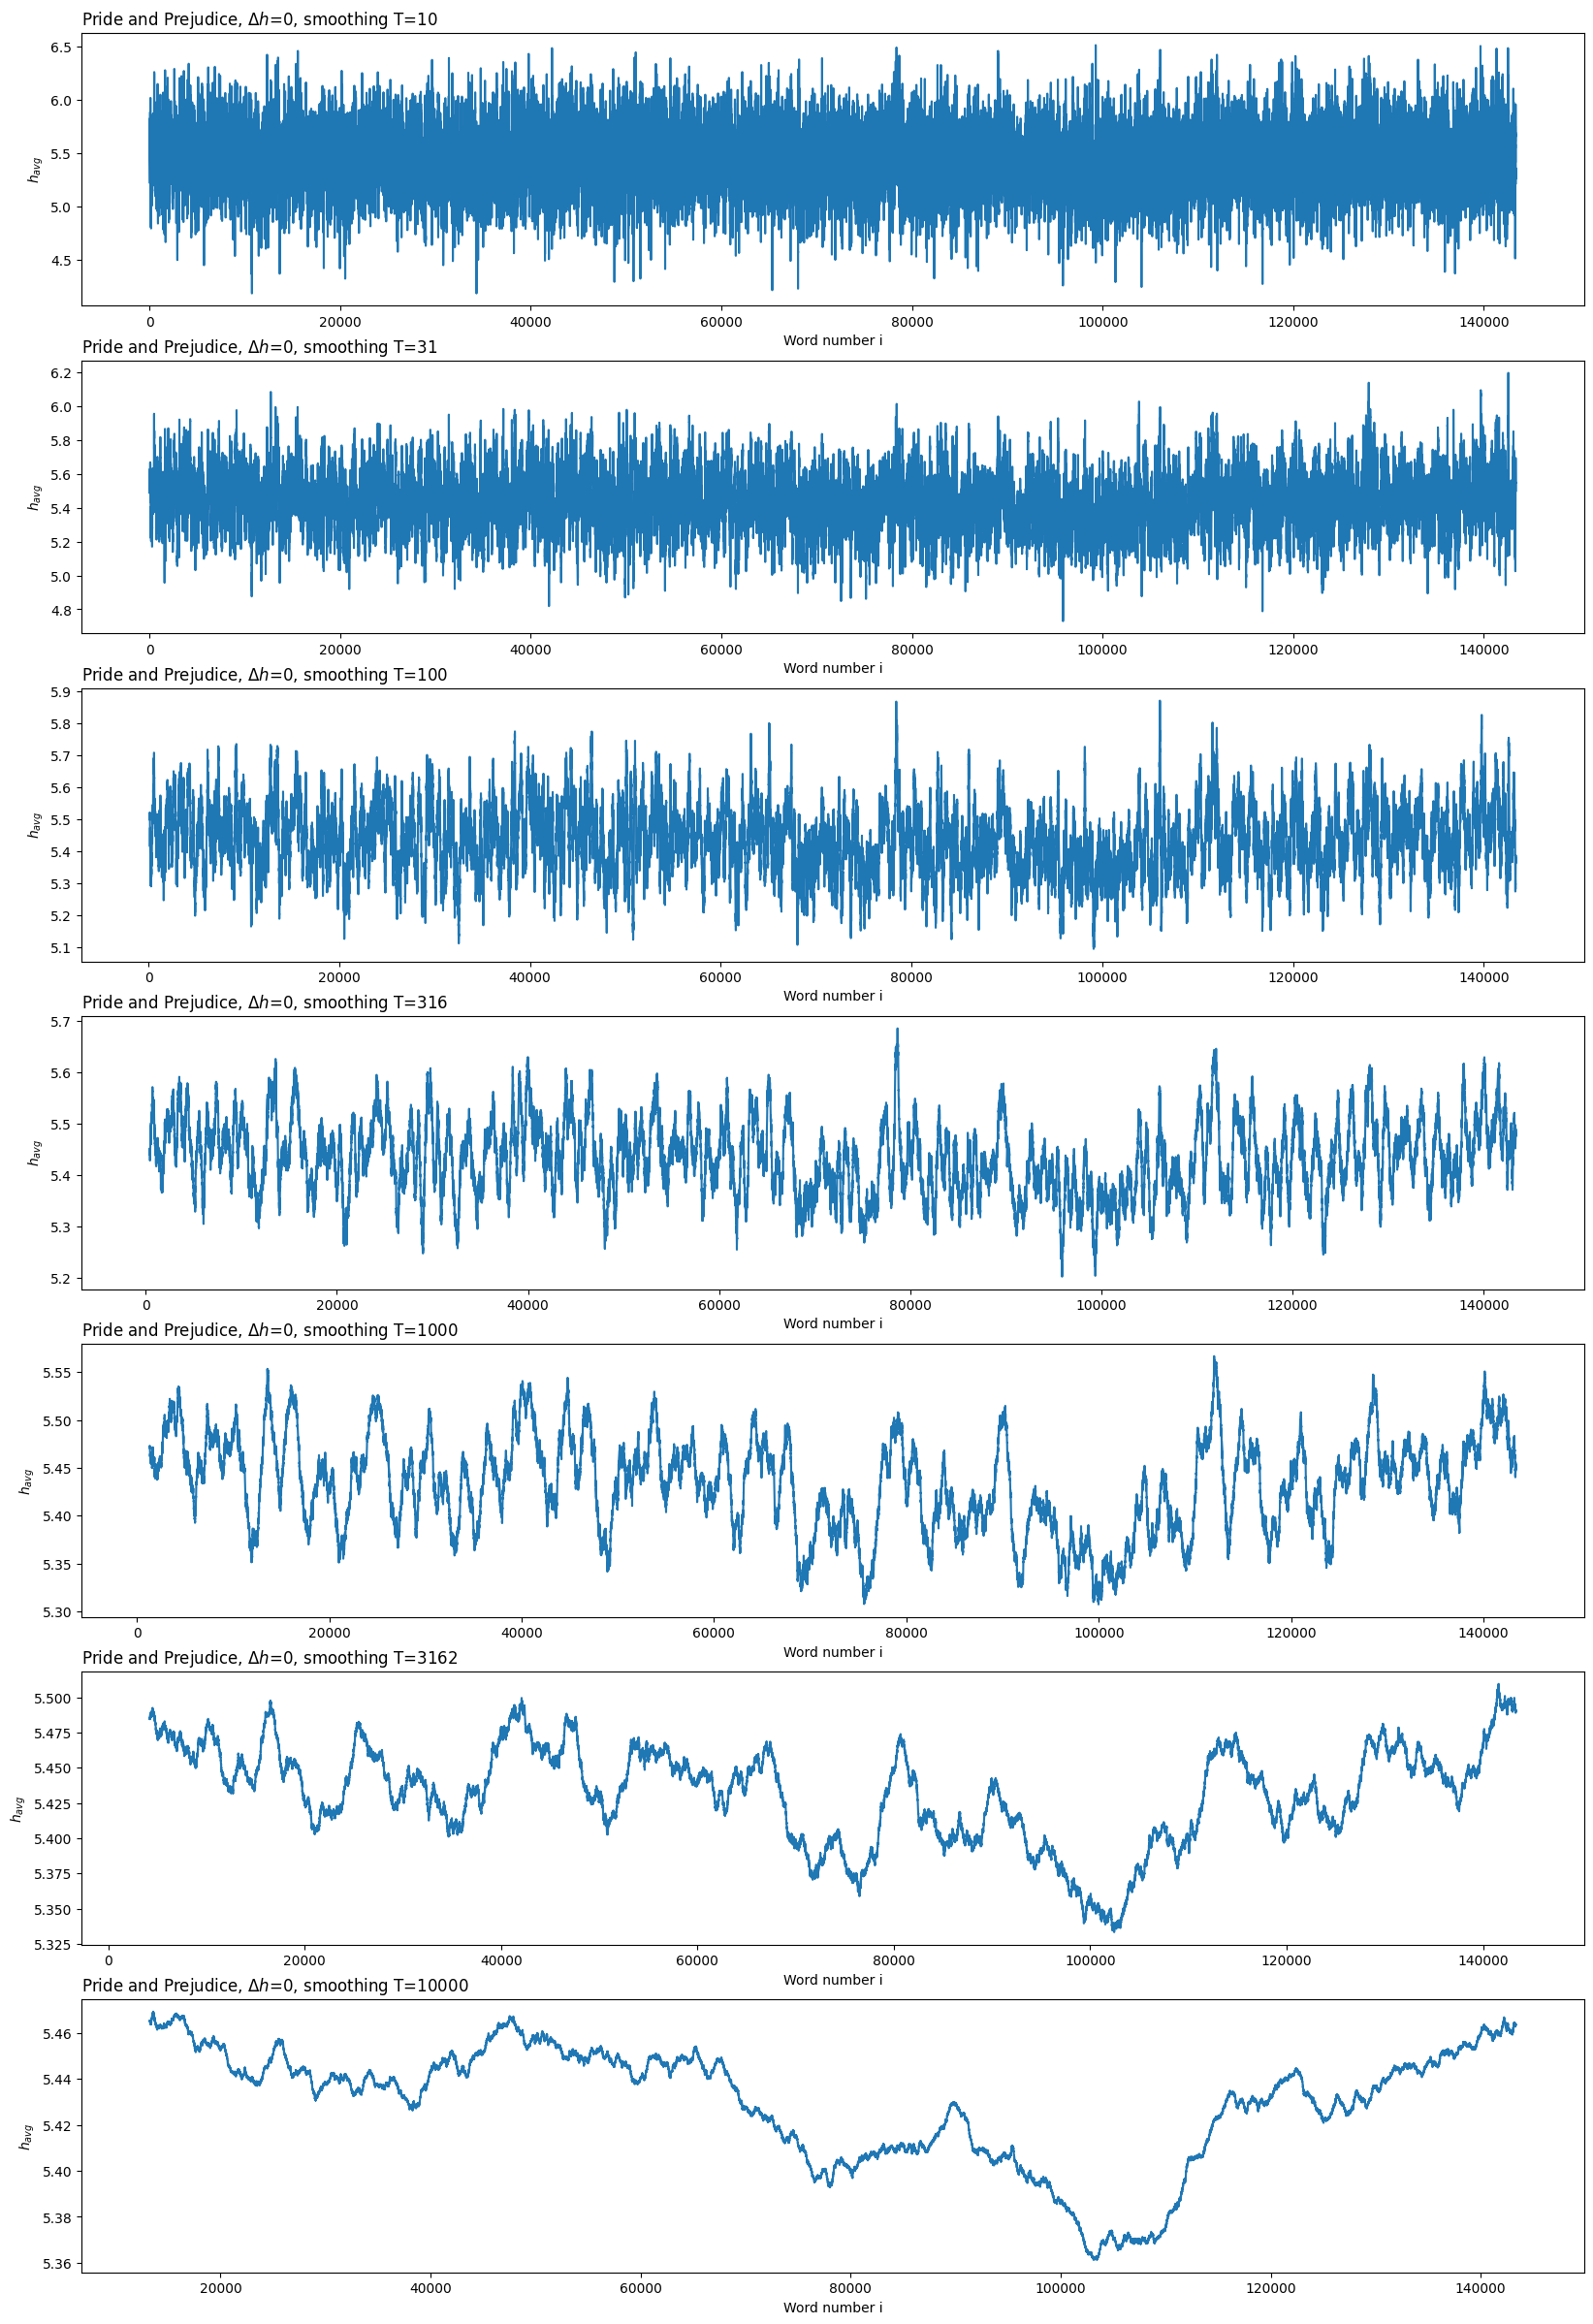

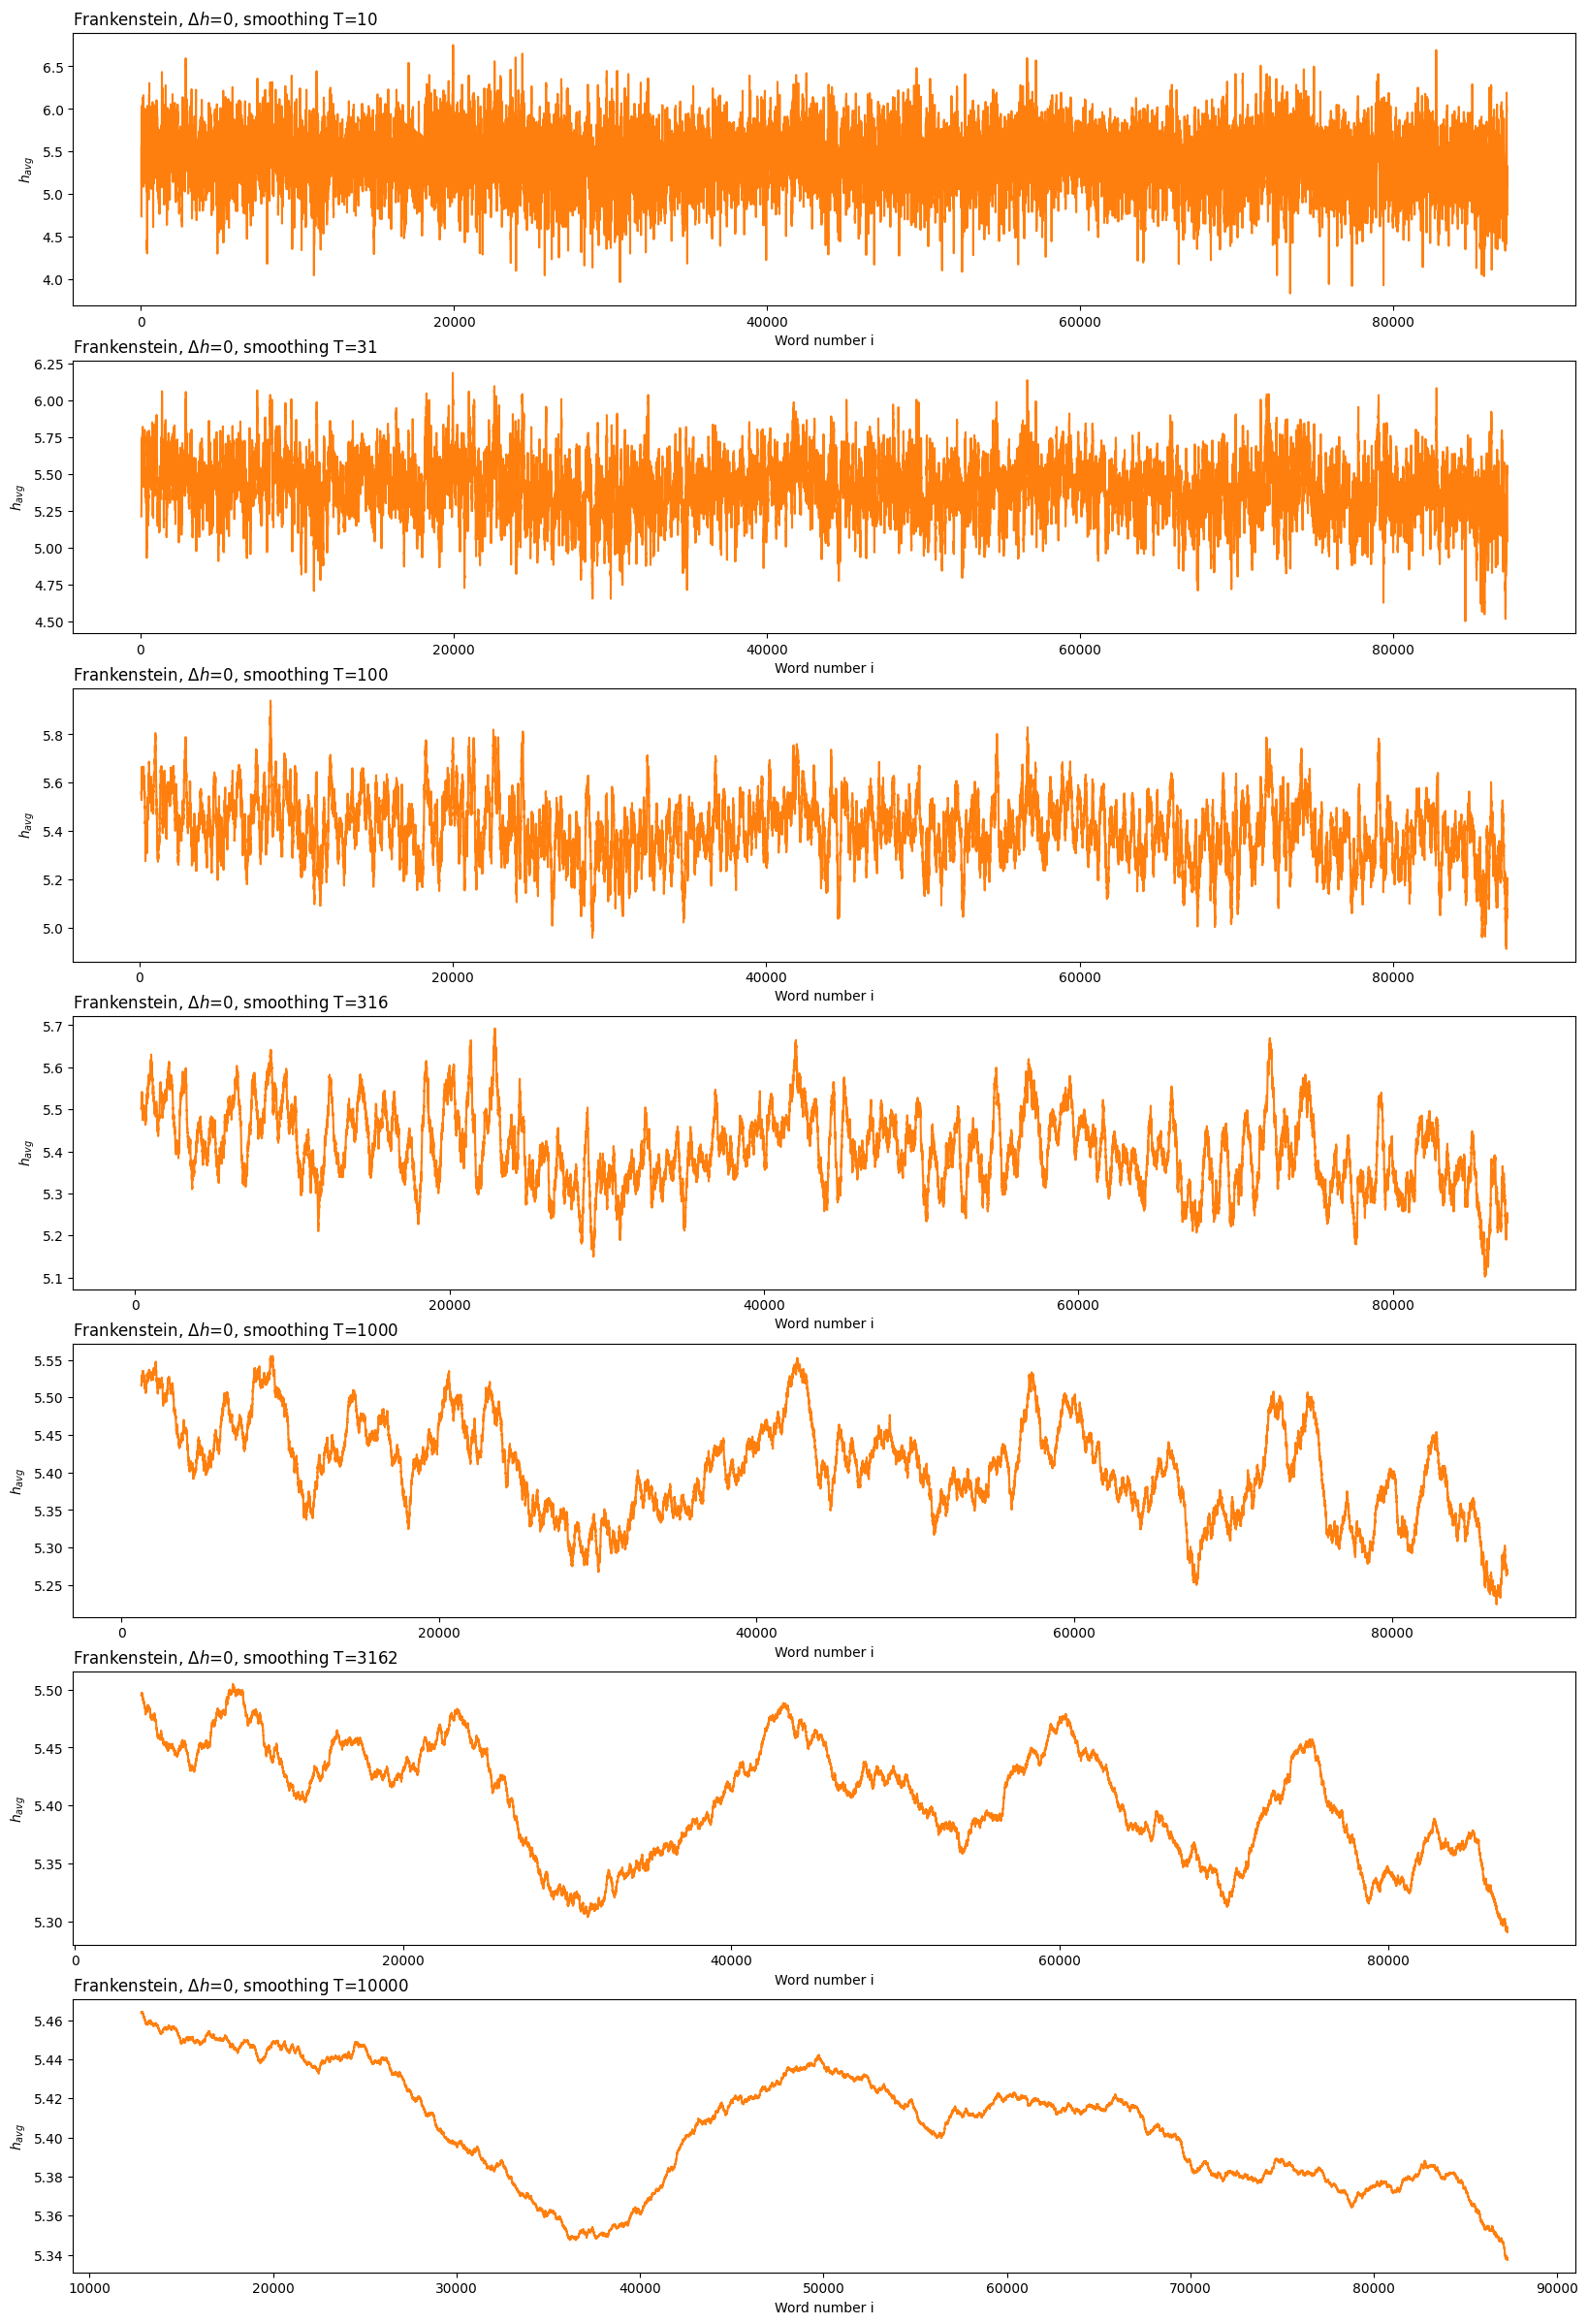

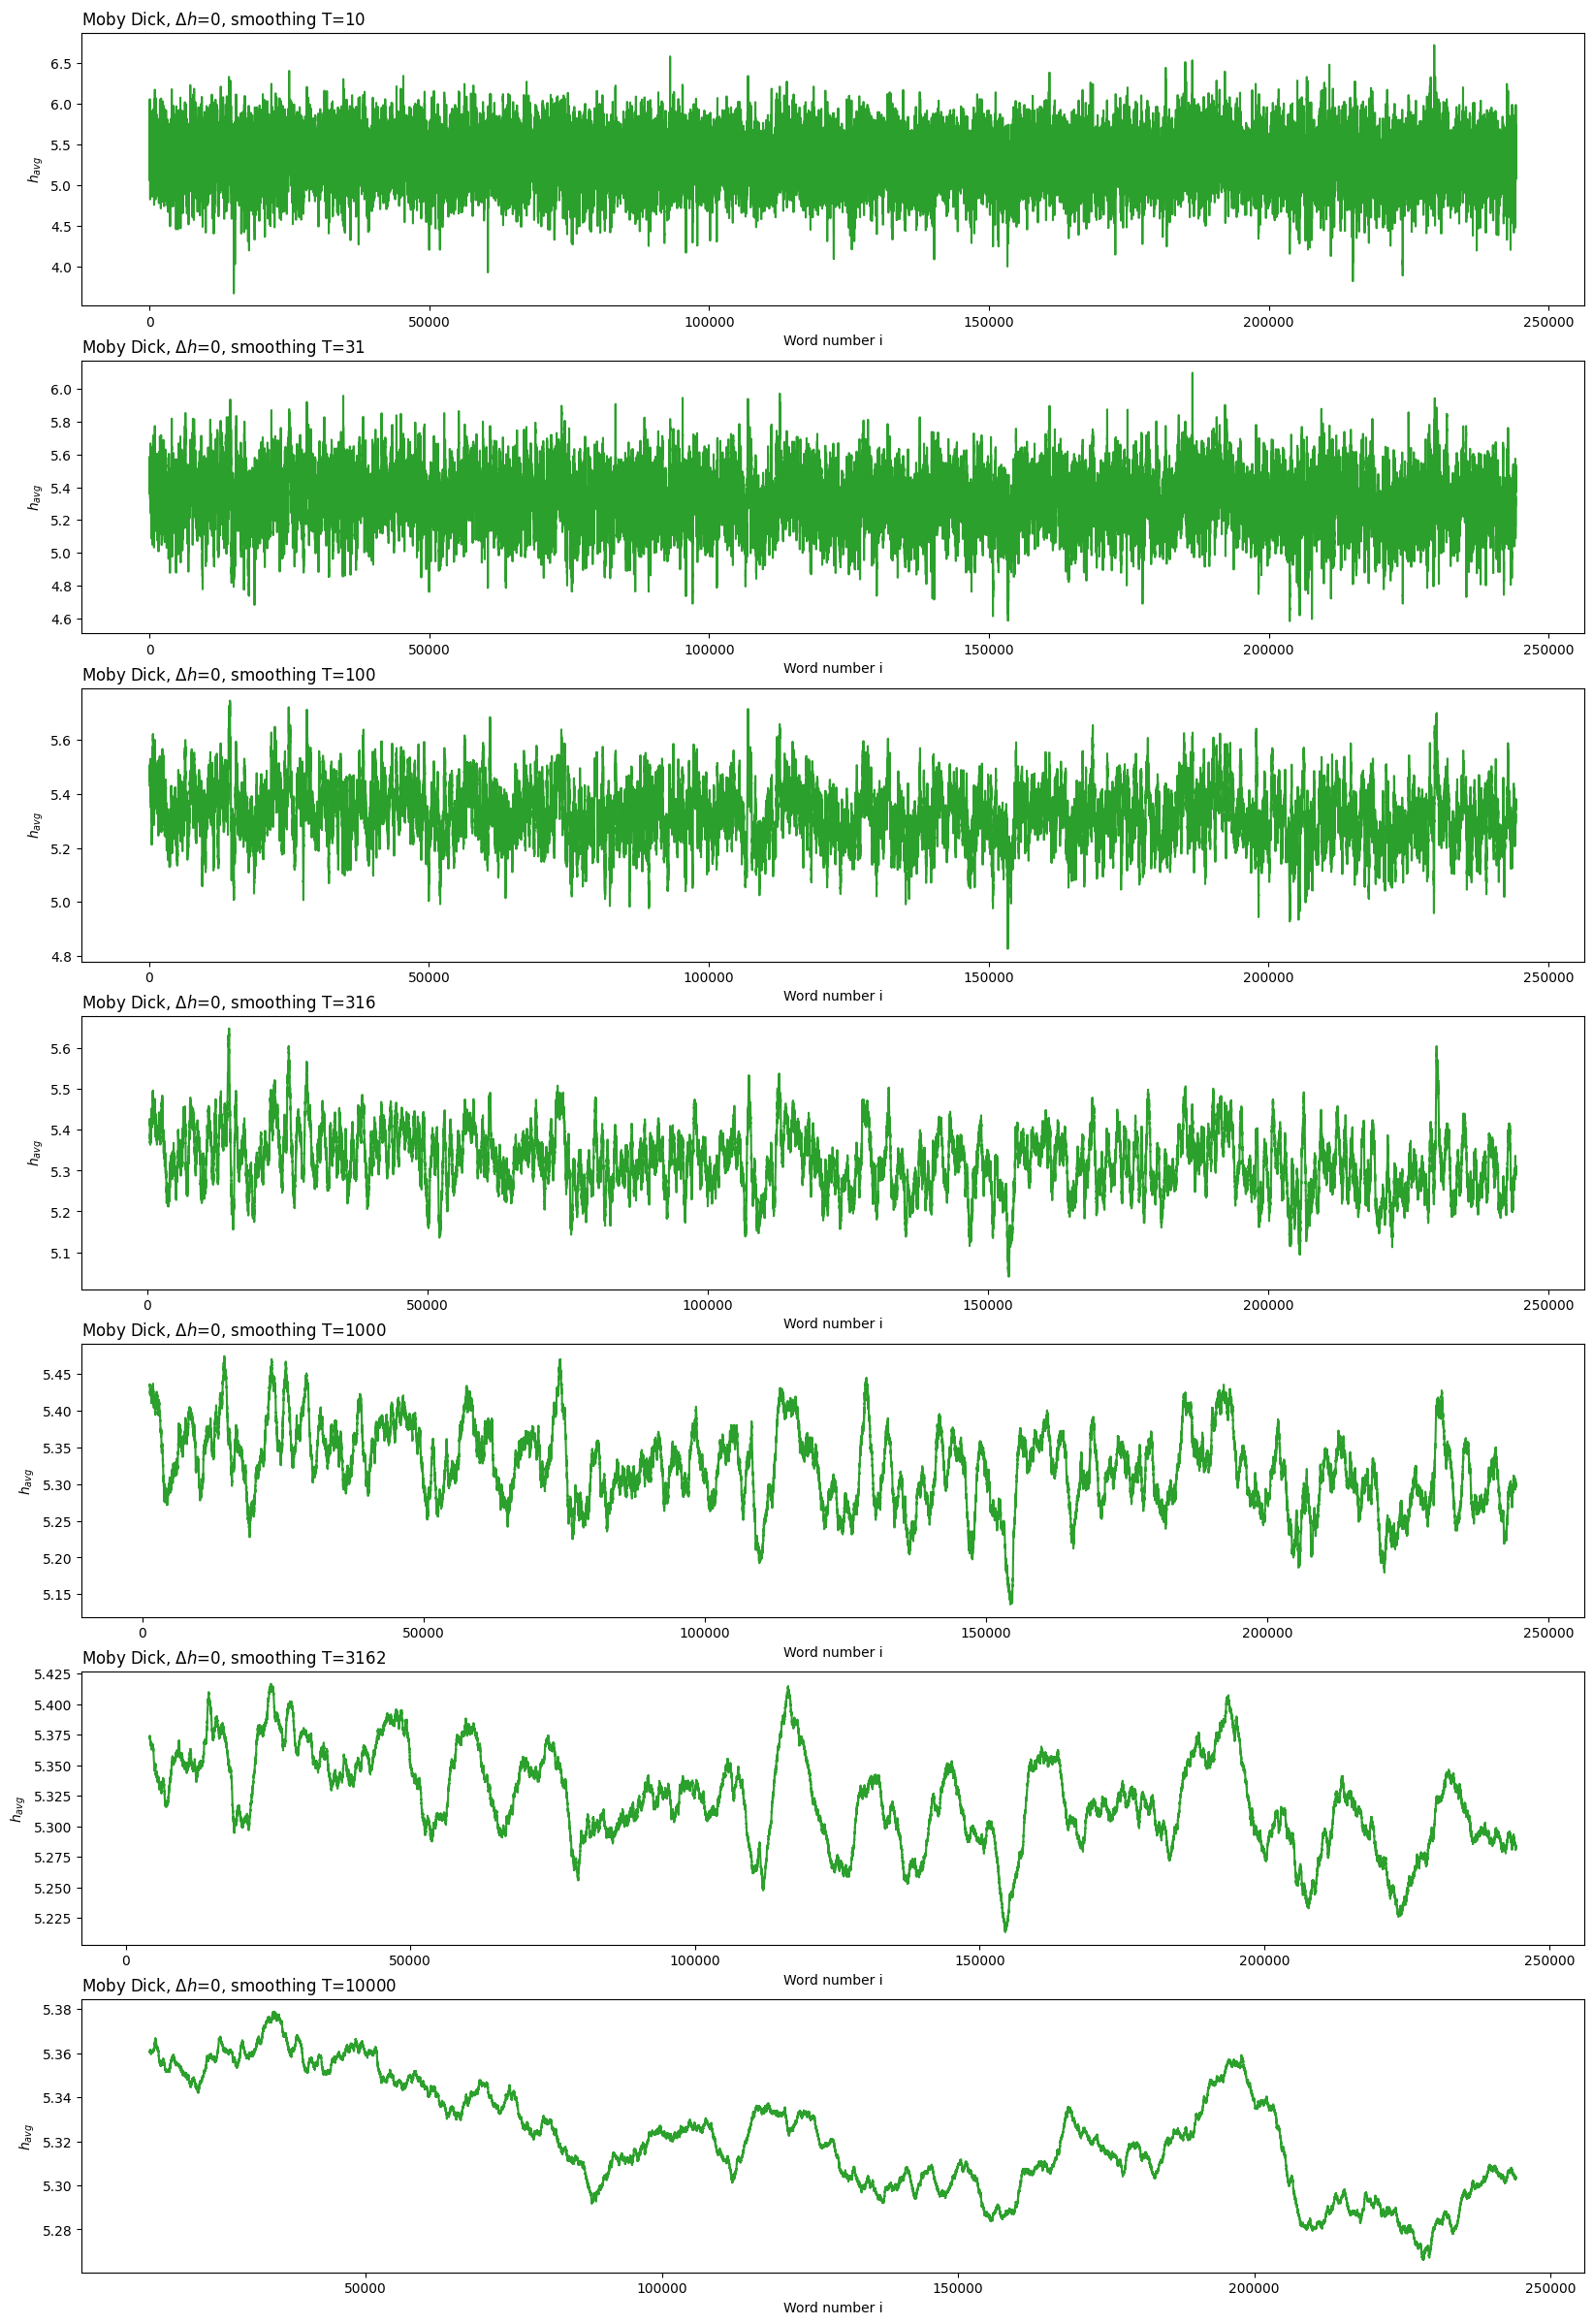

In [25]:
colors = plt.rcParams["axes.prop_cycle"]()
rename_text = {
    'pride_prej': 'Pride and Prejudice',
    'frankenstein': 'Frankenstein',
    'moby_dick': 'Moby Dick'
}

texts = texts.replace(rename_text)
corpora = pd.unique(texts['corpus'])
mu_list = [1, 1.5, 2, 2.5, 3, 3.5, 4.0]

for corpus in corpora:

    tmp = texts[texts['corpus'] == corpus]
    c = next(colors)["color"]
    
    compare_windows(tmp, corpus, mu_list, c)
    plt.savefig(f'../data/08_reporting/assign15_compare-windows_{corpus}.png', dpi=300, bbox_inches='tight')

[02/28/24 15:41:24] WARNING  /var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/ipykernel_82442/15392 ]8;id=595482;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=11527;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py#109\109]8;;\
                             47136.py:6: SettingWithCopyWarning:                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['h_smooth'] = df['happiness'].rolling(window=window).mean()                      
                                                                                                                   

                    WARNING  /var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/ipykernel_82442/15392 ]8;id=549251;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=180453;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py#109\109]8;;\
                             47136.py:6: SettingWithCopyWarning:                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['h_smooth'] = df['happiness'].rolling(window=window).mean()                      
                                                                                                                   

                    WARNING  /var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/ipykernel_82442/15392 ]8;id=352793;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=396887;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py#109\109]8;;\
                             47136.py:6: SettingWithCopyWarning:                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['h_smooth'] = df['happiness'].rolling(window=window).mean()                      
                                                                                                                   

[02/28/24 15:41:25] WARNING  /var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/ipykernel_82442/15392 ]8;id=536210;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=363380;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py#109\109]8;;\
                             47136.py:6: SettingWithCopyWarning:                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['h_smooth'] = df['happiness'].rolling(window=window).mean()                      
                                                                                                                   

                    WARNING  /var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/ipykernel_82442/15392 ]8;id=55377;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=773860;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py#109\109]8;;\
                             47136.py:6: SettingWithCopyWarning:                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['h_smooth'] = df['happiness'].rolling(window=window).mean()                      
                                                                                                                   

                    WARNING  /var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/ipykernel_82442/15392 ]8;id=787076;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=301757;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py#109\109]8;;\
                             47136.py:6: SettingWithCopyWarning:                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['h_smooth'] = df['happiness'].rolling(window=window).mean()                      
                                                                                                                   

                    WARNING  /var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/ipykernel_82442/15392 ]8;id=110947;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=572860;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py#109\109]8;;\
                             47136.py:6: SettingWithCopyWarning:                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['h_smooth'] = df['happiness'].rolling(window=window).mean()                      
                                                                                                                   

[02/28/24 15:41:27] WARNING  /var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/ipykernel_82442/15392 ]8;id=912834;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=693445;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py#109\109]8;;\
                             47136.py:6: SettingWithCopyWarning:                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['h_smooth'] = df['happiness'].rolling(window=window).mean()                      
                                                                                                                   

                    WARNING  /var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/ipykernel_82442/15392 ]8;id=695542;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=592589;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py#109\109]8;;\
                             47136.py:6: SettingWithCopyWarning:                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['h_smooth'] = df['happiness'].rolling(window=window).mean()                      
                                                                                                                   

                    WARNING  /var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/ipykernel_82442/15392 ]8;id=633261;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=404584;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py#109\109]8;;\
                             47136.py:6: SettingWithCopyWarning:                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['h_smooth'] = df['happiness'].rolling(window=window).mean()                      
                                                                                                                   

                    WARNING  /var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/ipykernel_82442/15392 ]8;id=912270;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=9293;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py#109\109]8;;\
                             47136.py:6: SettingWithCopyWarning:                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['h_smooth'] = df['happiness'].rolling(window=window).mean()                      
                                                                                                                   

                    WARNING  /var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/ipykernel_82442/15392 ]8;id=584375;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=258991;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py#109\109]8;;\
                             47136.py:6: SettingWithCopyWarning:                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['h_smooth'] = df['happiness'].rolling(window=window).mean()                      
                                                                                                                   

                    WARNING  /var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/ipykernel_82442/15392 ]8;id=912417;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=524278;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py#109\109]8;;\
                             47136.py:6: SettingWithCopyWarning:                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['h_smooth'] = df['happiness'].rolling(window=window).mean()                      
                                                                                                                   

                    WARNING  /var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/ipykernel_82442/15392 ]8;id=895517;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=148126;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py#109\109]8;;\
                             47136.py:6: SettingWithCopyWarning:                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['h_smooth'] = df['happiness'].rolling(window=window).mean()                      
                                                                                                                   

[02/28/24 15:41:29] WARNING  /var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/ipykernel_82442/15392 ]8;id=595830;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=861443;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py#109\109]8;;\
                             47136.py:6: SettingWithCopyWarning:                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['h_smooth'] = df['happiness'].rolling(window=window).mean()                      
                                                                                                                   

                    WARNING  /var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/ipykernel_82442/15392 ]8;id=305733;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=700754;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py#109\109]8;;\
                             47136.py:6: SettingWithCopyWarning:                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['h_smooth'] = df['happiness'].rolling(window=window).mean()                      
                                                                                                                   

                    WARNING  /var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/ipykernel_82442/15392 ]8;id=221641;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=57442;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py#109\109]8;;\
                             47136.py:6: SettingWithCopyWarning:                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['h_smooth'] = df['happiness'].rolling(window=window).mean()                      
                                                                                                                   

                    WARNING  /var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/ipykernel_82442/15392 ]8;id=457053;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=346445;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py#109\109]8;;\
                             47136.py:6: SettingWithCopyWarning:                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['h_smooth'] = df['happiness'].rolling(window=window).mean()                      
                                                                                                                   

[02/28/24 15:41:30] WARNING  /var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/ipykernel_82442/15392 ]8;id=888454;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=182767;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py#109\109]8;;\
                             47136.py:6: SettingWithCopyWarning:                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['h_smooth'] = df['happiness'].rolling(window=window).mean()                      
                                                                                                                   

                    WARNING  /var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/ipykernel_82442/15392 ]8;id=643243;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=575410;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py#109\109]8;;\
                             47136.py:6: SettingWithCopyWarning:                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['h_smooth'] = df['happiness'].rolling(window=window).mean()                      
                                                                                                                   

                    WARNING  /var/folders/zs/ktj9_xhs0lj_3bl3t0m0kwg40000gp/T/ipykernel_82442/15392 ]8;id=206804;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=365579;file:///Users/tony/anaconda3/envs/pocs/lib/python3.8/warnings.py#109\109]8;;\
                             47136.py:6: SettingWithCopyWarning:                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['h_smooth'] = df['happiness'].rolling(window=window).mean()                      
                                                                                                                   

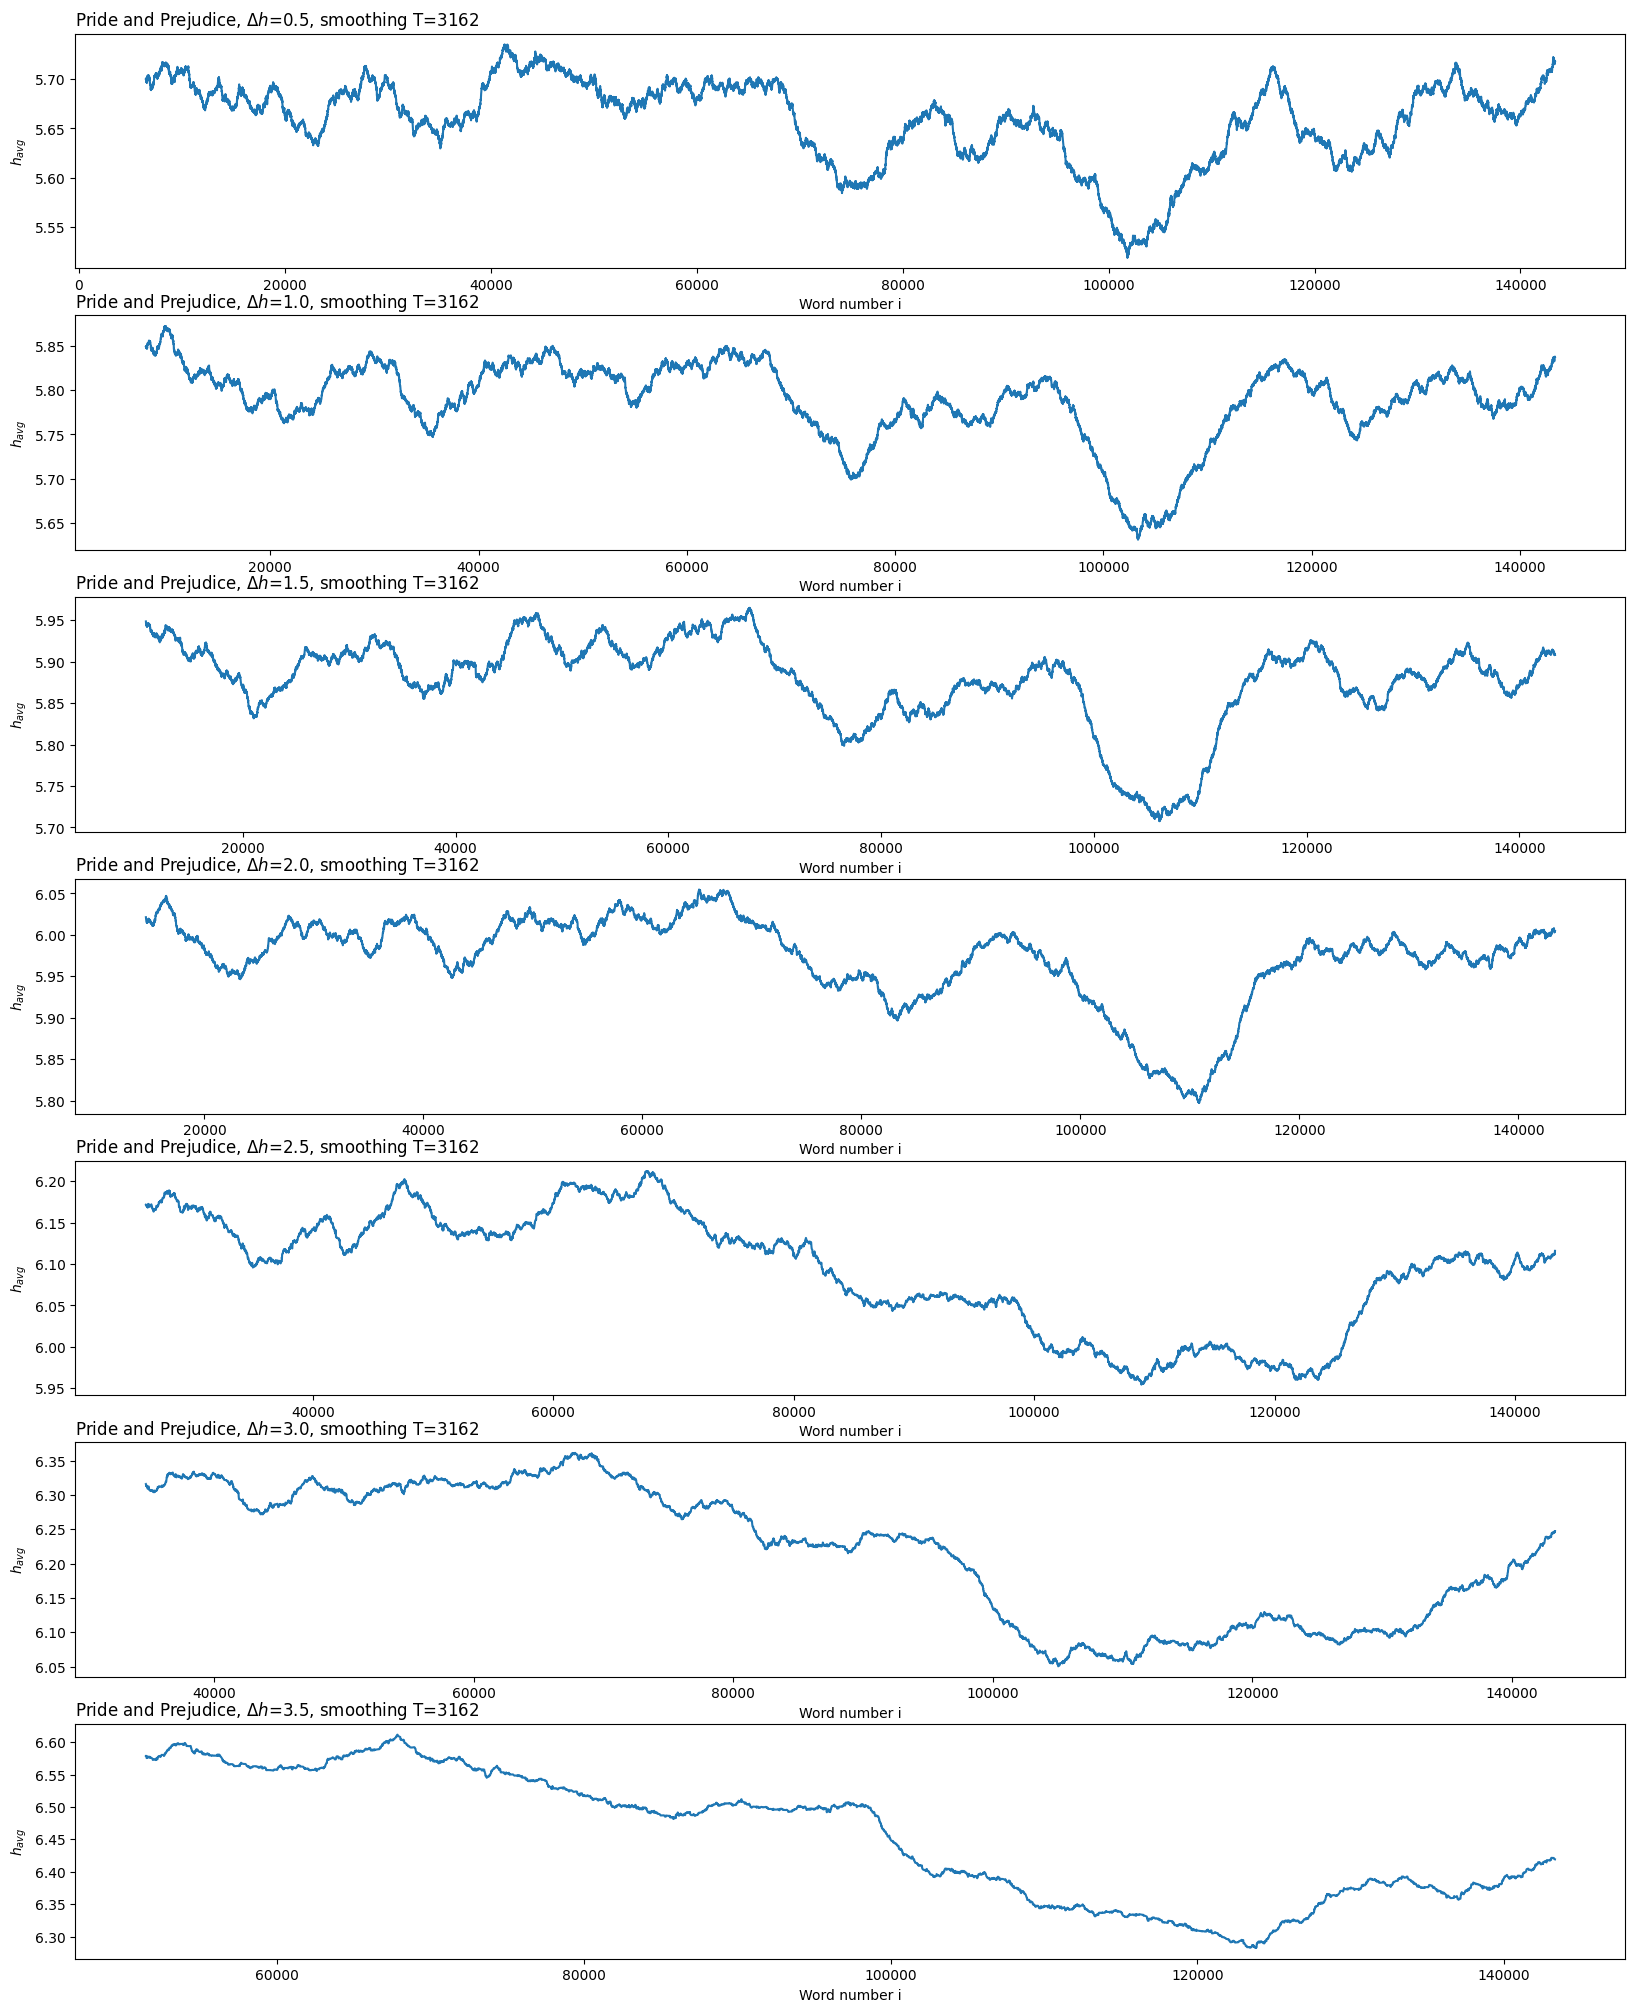

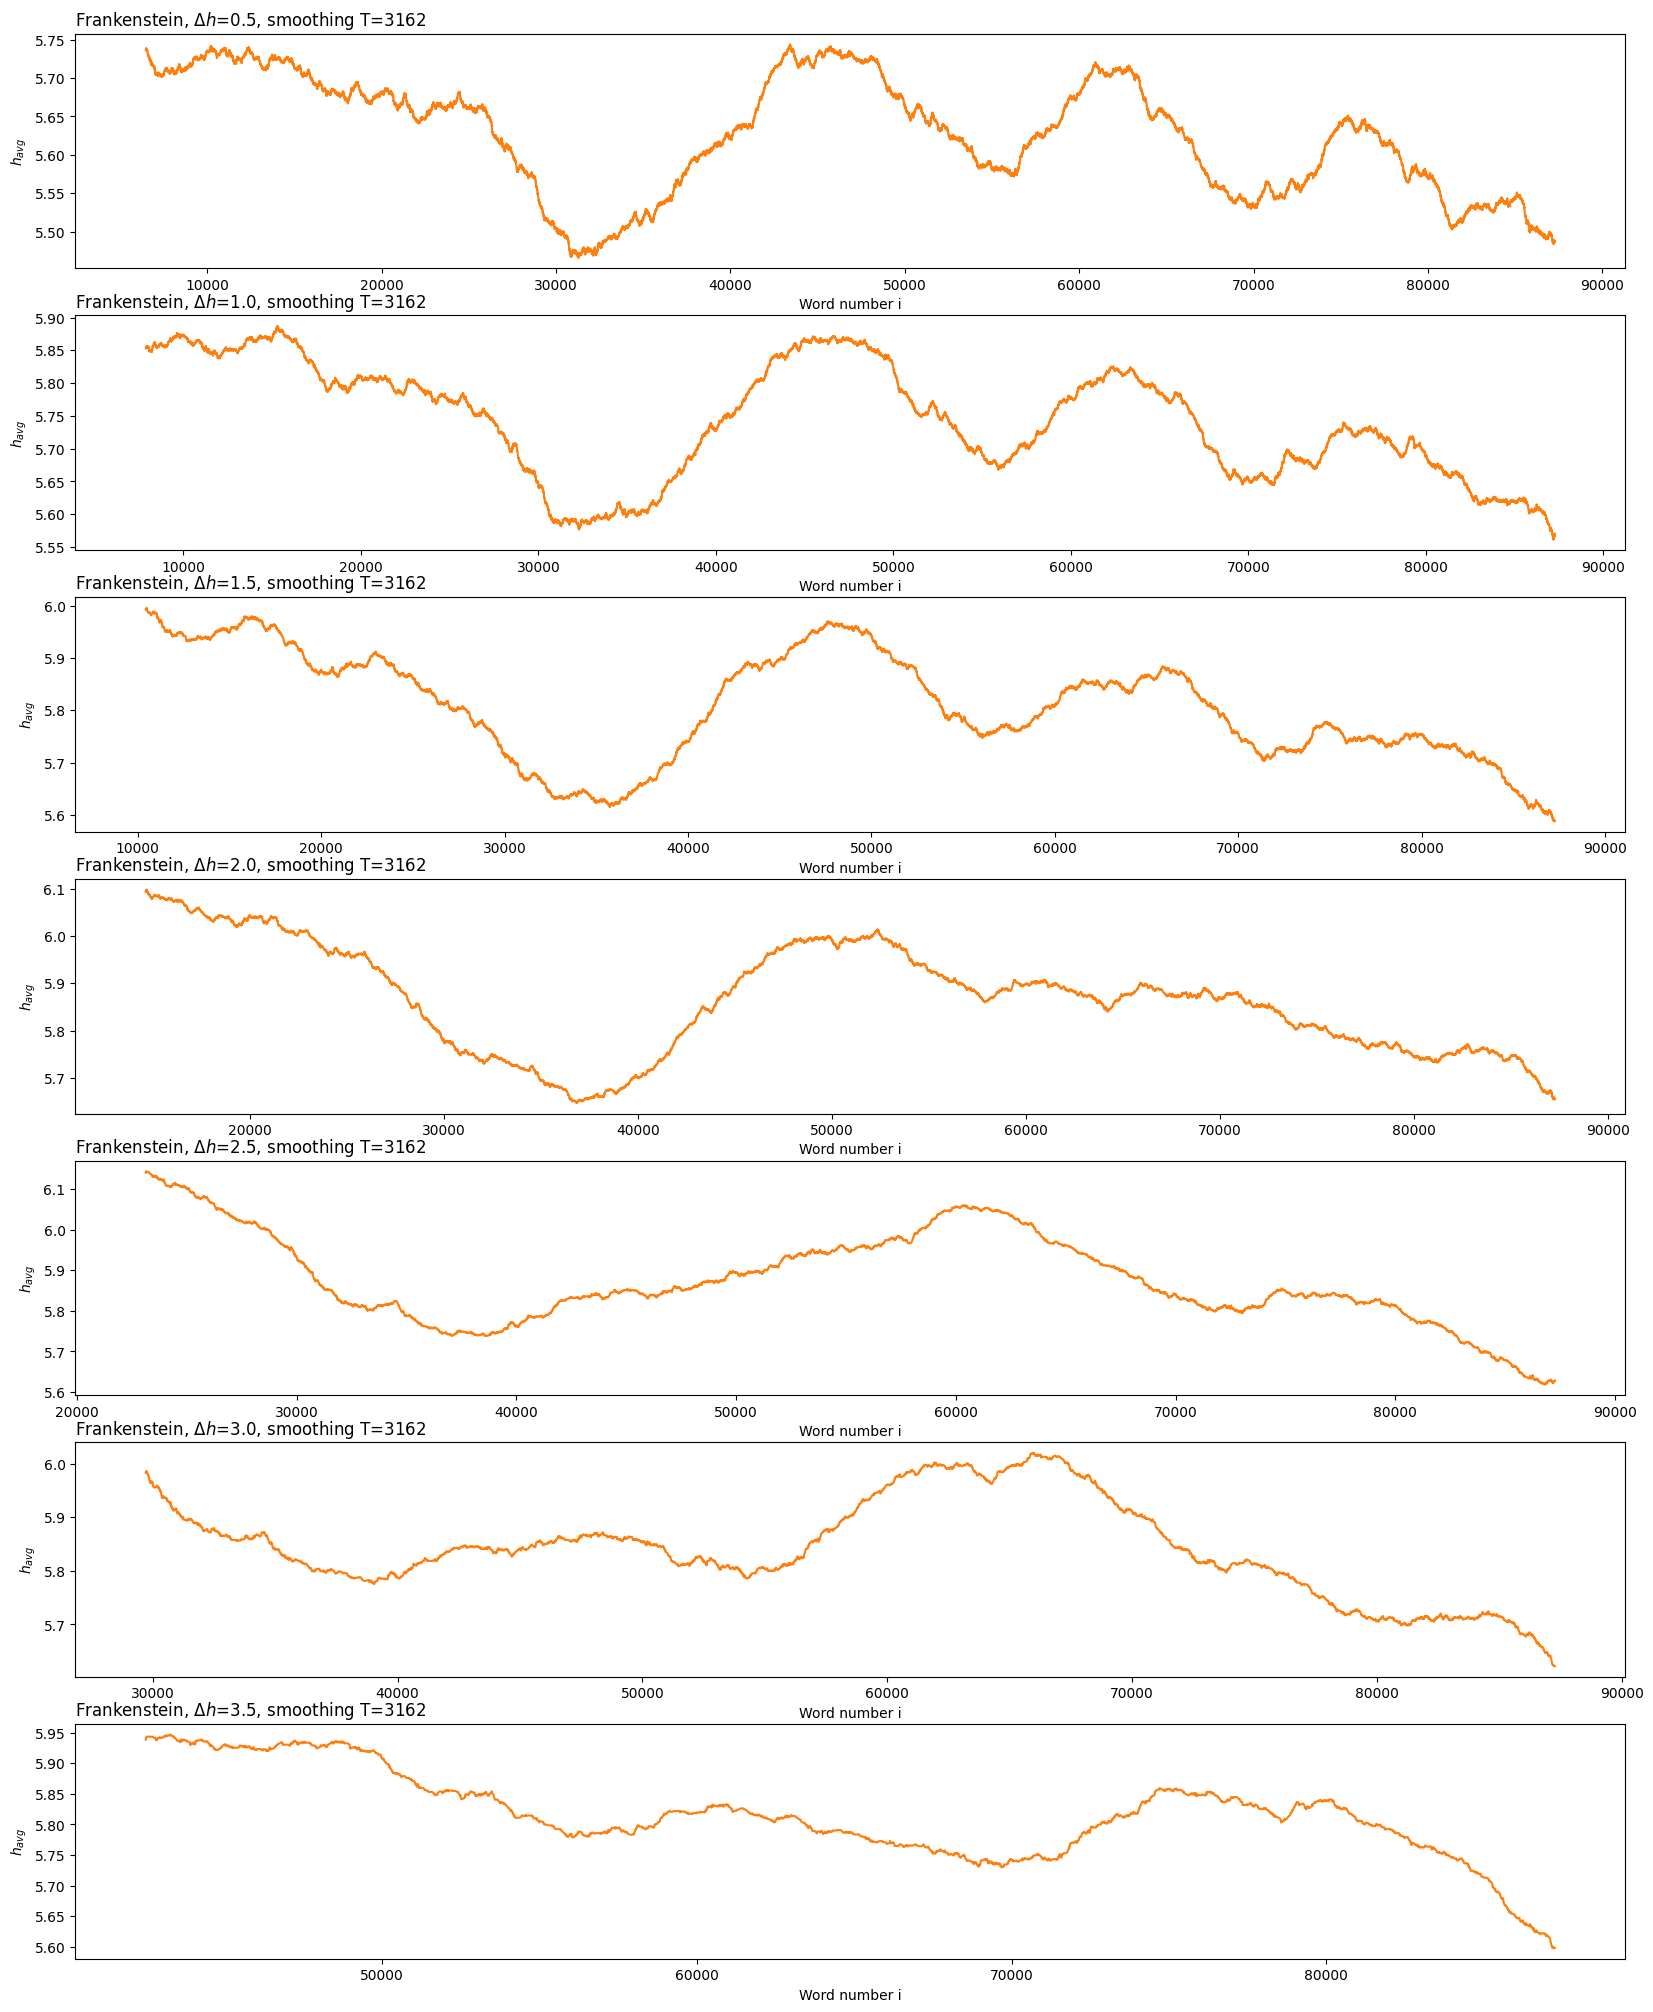

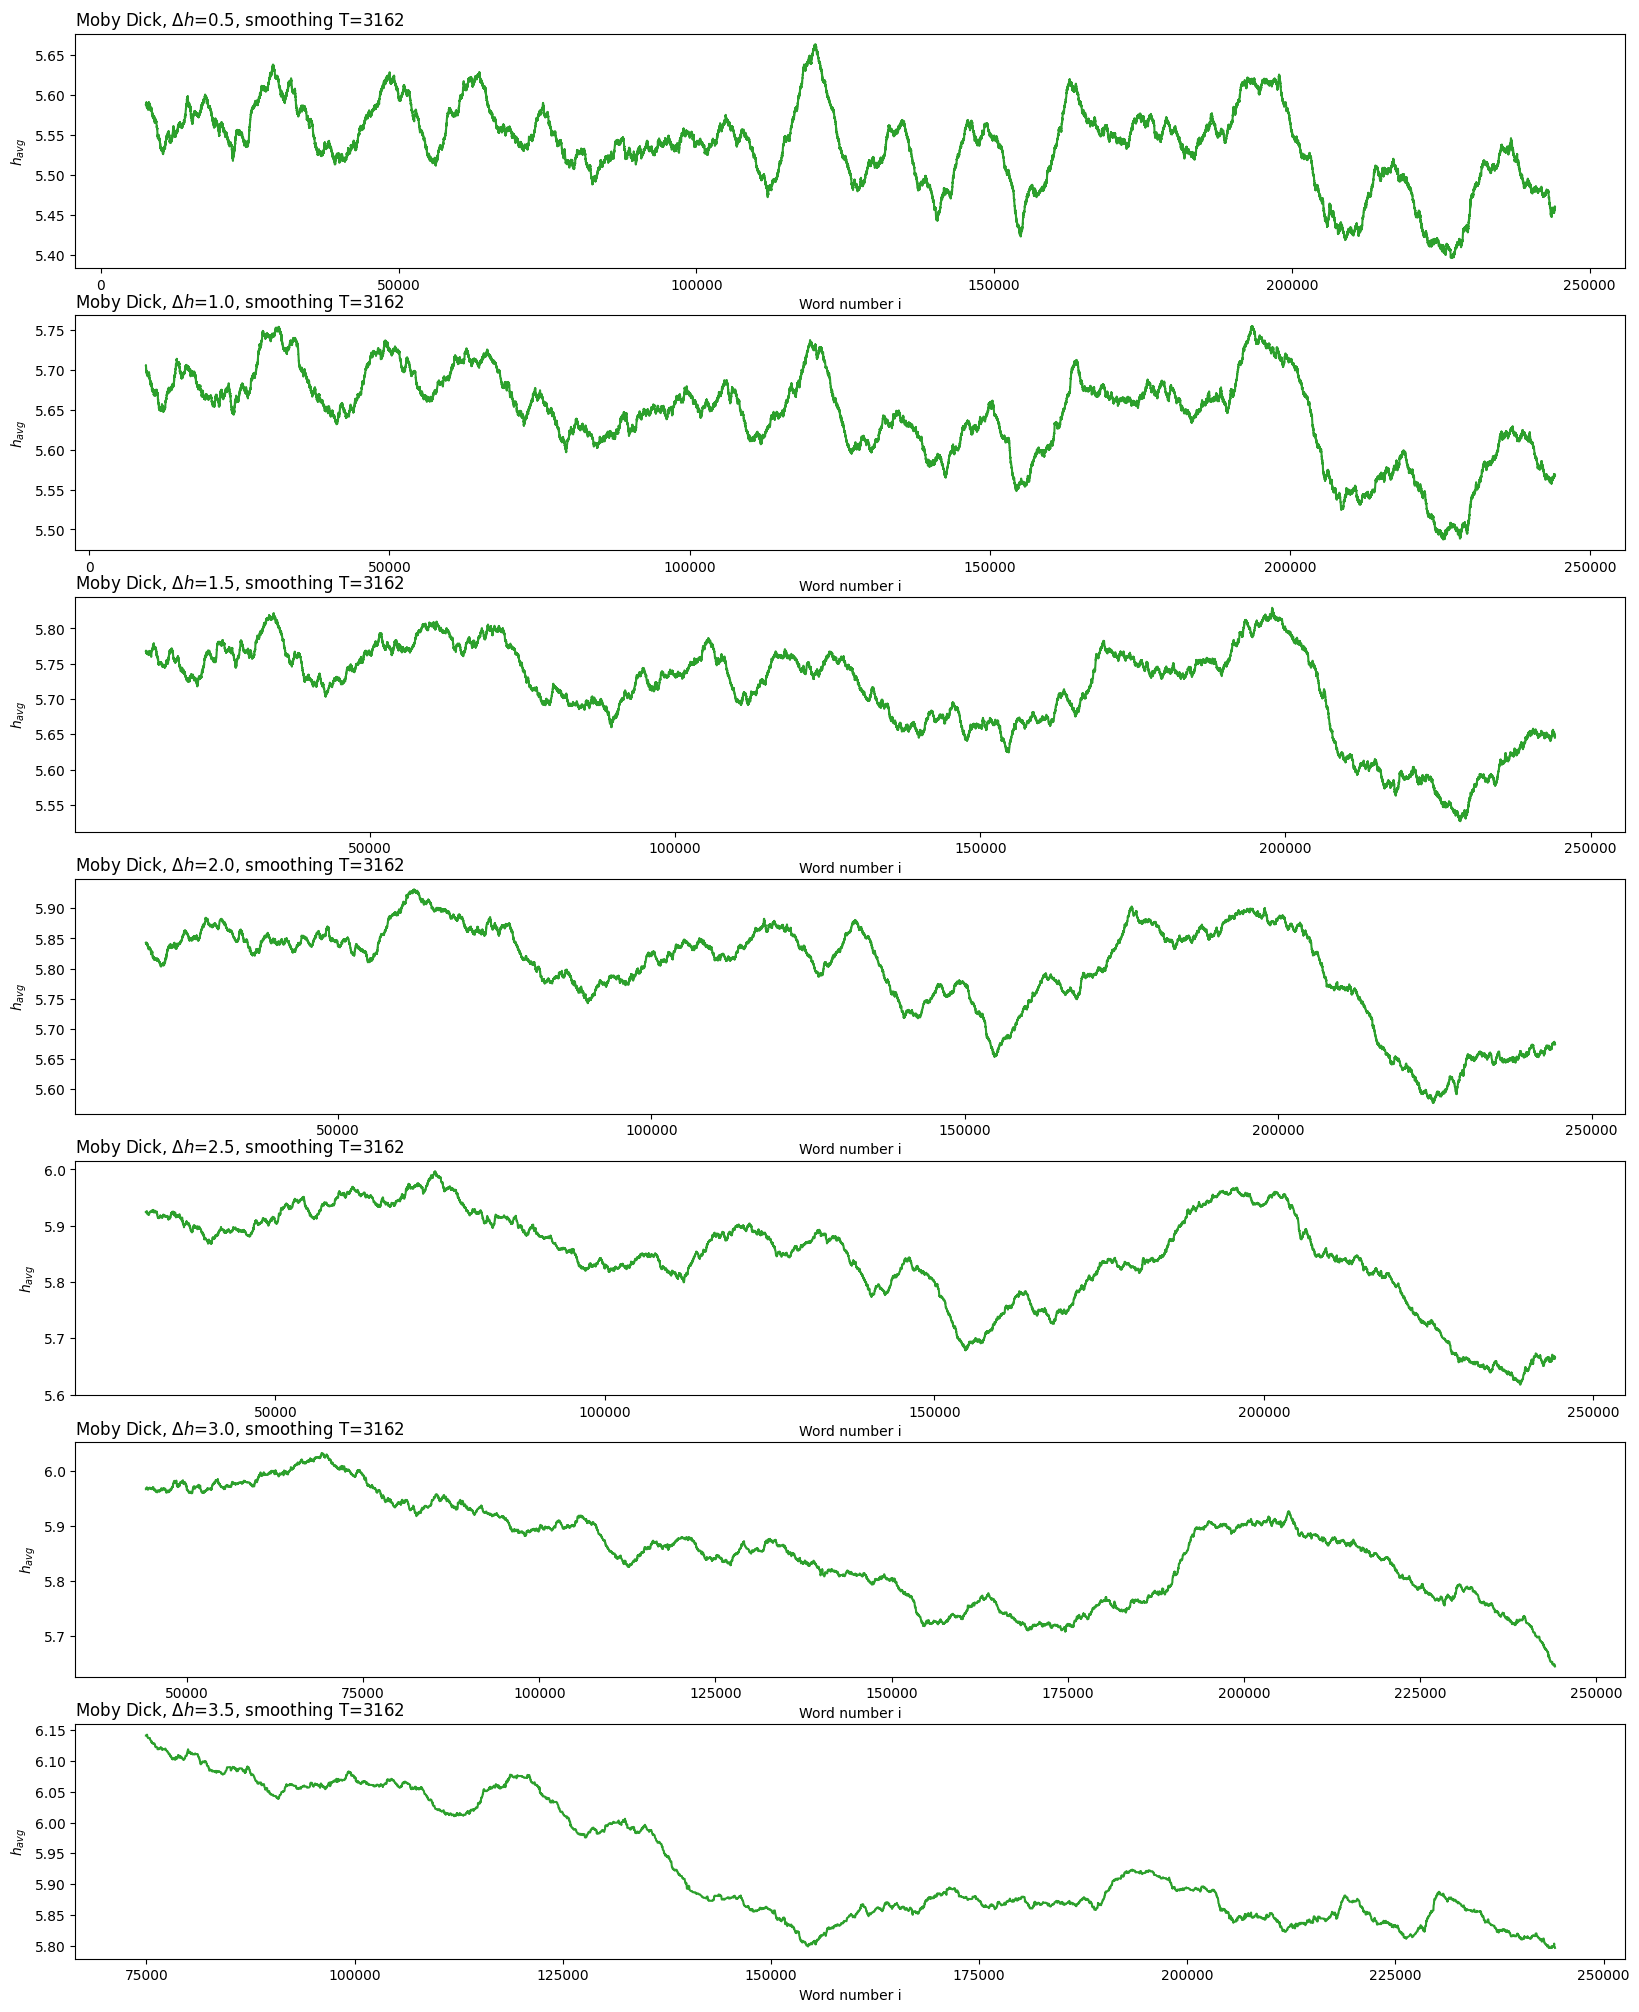

In [26]:
colors = plt.rcParams["axes.prop_cycle"]()
h_list = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]
for corpus in corpora:

    tmp = texts[texts['corpus'] == corpus]
    c = next(colors)["color"]
    
    compare_happiness(tmp, corpus, h_list, c, mu=3.5)
    plt.savefig(f'../data/08_reporting/assign15_compare-happiness_{corpus}.png', dpi=300, bbox_inches='tight')